In [ ]:
#Conectar con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importar paquetes de datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial 
import plotly.express as px
from matplotlib.pyplot import figure
import seaborn as sns
from datetime import datetime
import json
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression     ##Regresión Lineal
from sklearn.tree import DecisionTreeRegressor        ## Arbol de Decisión
from sklearn.ensemble import RandomForestRegressor    ## Bosque de regresión aleatorio
from sklearn.linear_model import SGDRegressor         ## Gradiente estocastico descendente 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RandomizedSearchCV

#**Definición de problema y diseño de solución**

**POBLEMA DE NEGOCIO**

El departamento de actuaria de UdeA Insurance no tiene claridad sobre las utilizaciones y los costos de servicios de salud, los cuales están dados por la ocurrencia de un evento que necesita intervención médica y que generan pérdidas o daños cuantificables en dinero; para así determinar el precio de un seguro de salud.

**PROBLEMA ANALÍTICO**

Con datos históricos disponibles de costos asociados a reclamaciones de servicios de salud se requiere construir un modelo de tarifación que asegure una precisión predictiva, para apoyar el área de ventas de UdeA Insurance buscando aportar de manera significativa a la optimización de recursos de la compañía de seguros.

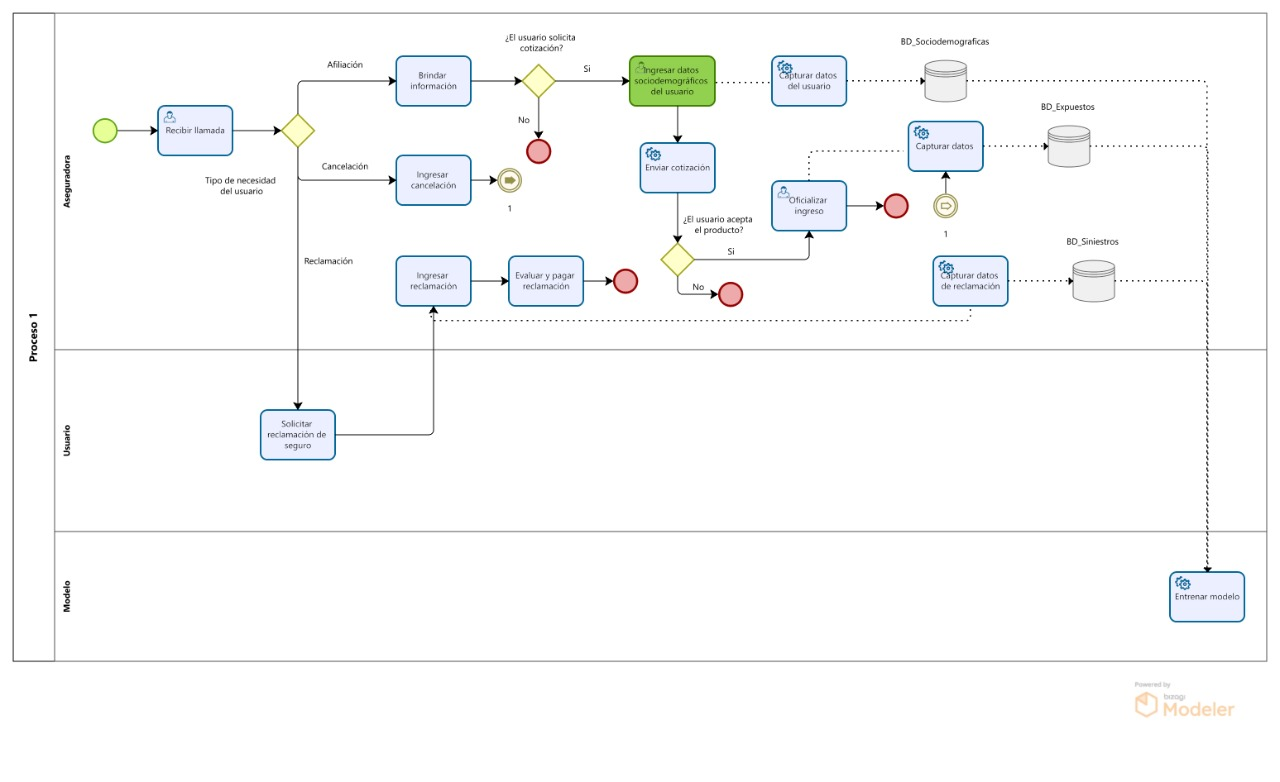

# **Limpieza y transformación**

##*Base: población expuesta*


###**Ingesta de datos**

In [ ]:
#Base de población expuesta (BD_Expuestos.txt)
expuestos =pd.read_csv('/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/BD_Expuestos.txt',sep ="\t")
expuestos.head(1)

,Asegurado_Id,Poliza_Asegurado_Id,FECHA_INICIO,FECHA_CANCELACION,FECHA_FIN
0,16286173,125696117,2018/01/01,2018/04/10,2018/04/10


In [ ]:
expuestos['Asegurado_Id'].value_counts().sort_values(ascending= False)

43841424    7
34629992    6
13175696    6
30787886    6
21611834    5
           ..
3197248     1
2326655     1
5740738     1
45847317    1
34905586    1
Name: Asegurado_Id, Length: 267233, dtype: int64

### **Forma**

**En este apartado se identifica la forma del dataset, donde se describe el nombre de las columnas, el tamaño de la base y el tipo de las variables**

In [ ]:
#Forma del DF
expuestos.shape                    #Tamaño
expuestos.columns                  #Nombre columnas
expuestos.dtypes                   #Tipo de variable
print("El tamaño del DF es",expuestos.shape )
print("El nombre de las columnas del DF es",expuestos.columns )
print("El tipo de variable de cada columna es")
print(expuestos.dtypes )

El tamaño del DF es (300900, 5)
El nombre de las columnas del DF es Index(['Asegurado_Id', 'Poliza_Asegurado_Id', 'FECHA_INICIO',
       'FECHA_CANCELACION', 'FECHA_FIN'],
      dtype='object')
El tipo de variable de cada columna es
Asegurado_Id            int64
Poliza_Asegurado_Id     int64
FECHA_INICIO           object
FECHA_CANCELACION      object
FECHA_FIN              object
dtype: object


### **Nulos**

**Se realiza un anàlisis de nulos con el objetivo de descartar a priori algunas variables que por su falta de datos, puedan complicar la realixaciòn del modelo.**



In [ ]:
nulos_expuestos = expuestos.isnull().sum()   
porcentaje_nulos = (nulos_expuestos/expuestos.shape[0])*100
porcentaje_nulos.sort_values(ascending = False).head(50)          

FECHA_CANCELACION      49.497175
Asegurado_Id            0.000000
Poliza_Asegurado_Id     0.000000
FECHA_INICIO            0.000000
FECHA_FIN               0.000000
dtype: float64

### **Fechas**

In [ ]:
expuestos['FECHA_INICIO'] = pd.to_datetime(expuestos['FECHA_INICIO'])
expuestos['FECHA_FIN'] = pd.to_datetime(expuestos['FECHA_FIN'])
expuestos['FECHA_CANCELACION'] = pd.to_datetime(expuestos['FECHA_CANCELACION'])

In [ ]:
expuestos = expuestos.sort_values('FECHA_INICIO',ascending= False).reset_index(inplace = False, drop=True) #Se ordena de ultimo a reciente para que se borren los registros mas antiguos

In [ ]:
expuestos_limpia = expuestos.drop_duplicates(subset=['Asegurado_Id'], keep = 'first').reset_index(inplace = False, drop=True)

In [ ]:
expuestos_limpia.head(3)

,Asegurado_Id,Poliza_Asegurado_Id,FECHA_INICIO,FECHA_CANCELACION,FECHA_FIN
0,5593708,206654893,2019-12-31,2019-12-31,2019-12-31
1,35297434,206689671,2019-12-31,2019-12-31,2019-12-31
2,23917236,206089202,2019-12-31,2019-12-31,2019-12-31


##*Base: costo y conteo de reclamaciones*

###**Ingesta de datos**

In [ ]:
#Base de Costo y reclamaciones (BD_Siniestros.txt)
siniestros =pd.read_csv('/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/DB_Siniestros.txt',sep ="\t", encoding='latin1')
siniestros.head(5)

,Mes_Pago,Asegurado_Id,Reclamacion,Diagnostico_Codigo,Diagnostico_Desc,Eventos,Valor_Pagado
0,201803,4834968,EXAMENES DE DIAGNOSTICO,Z011,EXAMEN DE OÍDOS Y DE LA AUDICIÓN,1,111600.00
1,201909,14915125,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,50468.00
2,201807,42959949,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,610452.00
3,201803,30540131,CONSULTA EXTERNA,9,DIAGNÓSTICO PENDIENTE,1,42160.00
4,201905,21442420,LABORATORIO CLINICO,9,DIAGNÓSTICO PENDIENTE,18,617336.48


### **Forma**

**En este apartado se identifica la forma del dataset, donde se describe el nombre de las columnas, el tamaño de la base y el tipo de las variables**

In [ ]:
#Forma del DF
siniestros.shape                    #Tamaño
siniestros.columns                  #Nombre columnas
siniestros.dtypes                   #Tipo de variable
print("El tamaño del DF es",siniestros.shape )
print("El nombre de las columnas del DF es",siniestros.columns )
print("El tipo de variable de cada columna es")
print(siniestros.dtypes )

El tamaño del DF es (3308480, 7)
El nombre de las columnas del DF es Index(['Mes_Pago', 'Asegurado_Id', 'Reclamacion', 'Diagnostico_Codigo',
       'Diagnostico_Desc', 'Eventos', 'Valor_Pagado'],
      dtype='object')
El tipo de variable de cada columna es
Mes_Pago                int64
Asegurado_Id            int64
Reclamacion            object
Diagnostico_Codigo     object
Diagnostico_Desc       object
Eventos                 int64
Valor_Pagado          float64
dtype: object


### **Nulos**

**Se realiza un anàlisis de nulos con el objetivo de descartar a priori algunas variables que por su falta de datos, puedan complicar la realixaciòn del modelo.**



In [ ]:
nulos_siniestros = siniestros.isnull().sum()   
porcentaje_nulos = (nulos_siniestros/siniestros.shape[0])*100
porcentaje_nulos.sort_values(ascending = False).head(50)          

Mes_Pago              0.0
Asegurado_Id          0.0
Reclamacion           0.0
Diagnostico_Codigo    0.0
Diagnostico_Desc      0.0
Eventos               0.0
Valor_Pagado          0.0
dtype: float64

### **Fechas**

In [ ]:
#Pasamos a string el mes para extraer de esa variable el año y el mes de pago en 2 columnas diferentes y luego se elimina la inicial
siniestros['Mes_Pago'] =siniestros['Mes_Pago'].astype(str)
siniestros['Mes_pago'] =(siniestros['Mes_Pago'].str[4:6])
siniestros['Año_pago'] =(siniestros['Mes_Pago'].str[0:4])
siniestros['Mes_pago'] =siniestros['Mes_pago'].astype(int)
siniestros['Año_pago'] =siniestros['Año_pago'].astype(int)
siniestros = siniestros.drop(['Mes_Pago'],axis=1)

In [ ]:
siniestros =siniestros.drop_duplicates()

##*Base: características sociodemográficas*

###**Ingesta de datos**

In [ ]:
#Base de población expuesta (BD_Expuestos.txt)
sociodemograficas =pd.read_csv('/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/BD_Sociodemograficas.txt',sep ="\t",encoding='latin1')
sociodemograficas.head(1)

,Asegurado_Id,Sexo_Cd,FechaNacimiento,Regional,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
0,18686469,F,1984/01/17,REGIONAL ANTIOQUIA,0,0,0,0,0


### **Forma**

**En este apartado se identifica la forma del dataset, donde se describe el nombre de las columnas, el tamaño de la base y el tipo de las variables**

In [ ]:
#Forma del DF
sociodemograficas.shape                    #Tamaño
sociodemograficas.columns                  #Nombre columnas
sociodemograficas.dtypes                   #Tipo de variable
print("El tamaño del DF es",sociodemograficas.shape )
print("El nombre de las columnas del DF es",sociodemograficas.columns )
print("El tipo de variable de cada columna es")
print(sociodemograficas.dtypes )

El tamaño del DF es (267312, 9)
El nombre de las columnas del DF es Index(['Asegurado_Id', 'Sexo_Cd', 'FechaNacimiento', 'Regional', 'CANCER',
       'EPOC', 'DIABETES', 'HIPERTENSION', 'ENF_CARDIOVASCULAR'],
      dtype='object')
El tipo de variable de cada columna es
Asegurado_Id           int64
Sexo_Cd               object
FechaNacimiento       object
Regional              object
CANCER                 int64
EPOC                   int64
DIABETES               int64
HIPERTENSION           int64
ENF_CARDIOVASCULAR     int64
dtype: object


### **Nulos**

**Se realiza un anàlisis de nulos con el objetivo de descartar a priori algunas variables que por su falta de datos, puedan complicar la realixaciòn del modelo.**



In [ ]:
nulos_sociodemograficos = sociodemograficas.isnull().sum()   
porcentaje_nulos = (nulos_sociodemograficos/sociodemograficas.shape[0])*100
porcentaje_nulos.sort_values(ascending = False).head(50)          

Regional              0.000374
Asegurado_Id          0.000000
Sexo_Cd               0.000000
FechaNacimiento       0.000000
CANCER                0.000000
EPOC                  0.000000
DIABETES              0.000000
HIPERTENSION          0.000000
ENF_CARDIOVASCULAR    0.000000
dtype: float64

In [ ]:
#Se elimina fila con registro nulo
sociodemograficas= sociodemograficas.dropna(axis=0)
sociodemograficas

,Asegurado_Id,Sexo_Cd,FechaNacimiento,Regional,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR
0,18686469,F,1984/01/17,REGIONAL ANTIOQUIA,0,0,0,0,0
1,16087775,M,1984/03/12,REGIONAL NORTE,0,0,0,0,0
2,35757761,F,1993/12/19,REGIONAL ANTIOQUIA,0,0,0,0,0
3,48691460,M,2000/11/14,REGIONAL ANTIOQUIA,0,0,0,0,0
4,36074099,F,2015/08/06,REGIONAL CENTRO,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
267307,21676160,F,1988/01/21,REGIONAL ANTIOQUIA,0,0,0,0,0
267308,4782725,F,1975/01/23,REGIONAL CENTRO,0,0,0,0,0
267309,10100593,F,1975/07/04,REGIONAL NORTE,1,0,0,0,0
267310,34178573,F,1978/10/15,REGIONAL CENTRO,0,0,0,0,0


In [ ]:
sociodemograficas['Asegurado_Id'] =sociodemograficas['Asegurado_Id'].drop_duplicates()
#sociodemograficas['Asegurado_Id'].value_counts().sort_values(ascending=False) - para validar duplicados por usuario

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


##Unión conjunto de datos

In [ ]:
df1 = siniestros.merge(sociodemograficas, on=('Asegurado_Id'), how='left')
df1 = df1.dropna(axis = 0)
df2 = df1.merge(expuestos_limpia, on=('Asegurado_Id'), how='left')
#estancia_promedio.shape
df2.head(3)

,Asegurado_Id,Reclamacion,Diagnostico_Codigo,Diagnostico_Desc,Eventos,Valor_Pagado,Mes_pago,Año_pago,Sexo_Cd,FechaNacimiento,Regional,CANCER,EPOC,DIABETES,HIPERTENSION,ENF_CARDIOVASCULAR,Poliza_Asegurado_Id,FECHA_INICIO,FECHA_CANCELACION,FECHA_FIN
0,4834968,EXAMENES DE DIAGNOSTICO,Z011,EXAMEN DE OÍDOS Y DE LA AUDICIÓN,1,111600.0,3,2018,M,1969/10/30,REGIONAL CENTRO,0.0,0.0,0.0,1.0,0.0,95576925,2018-01-01,2019-12-31,2019-12-31
1,14915125,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,50468.0,9,2019,F,1983/03/26,REGIONAL CENTRO,0.0,0.0,0.0,0.0,0.0,131484861,2018-01-01,NaT,2019-12-31
2,42959949,EXAMENES DE DIAGNOSTICO,9,DIAGNÓSTICO PENDIENTE,1,610452.0,7,2018,F,1987/03/12,REGIONAL CENTRO,0.0,0.0,0.0,0.0,0.0,158787897,2018-01-01,NaT,2019-12-31


###Análisis datos nulos y otros tratamientos

*Se realiza un análisis de nulos con el objetivo de descartar a priori algunas variables que por su falta de datos, puedan complicar el desarrollo del modelo.*



In [ ]:
#visualización cantidad y porcentaje de datos nulos
nulos_union = df2.isnull().sum()   
porcentaje_nulos = (nulos_union/df2.shape[0])*100
print(porcentaje_nulos.sort_values(ascending = False).head(50))
print('------------------')          
print(nulos_union)

FECHA_CANCELACION      64.728025
Asegurado_Id            0.000000
Reclamacion             0.000000
FECHA_INICIO            0.000000
Poliza_Asegurado_Id     0.000000
ENF_CARDIOVASCULAR      0.000000
HIPERTENSION            0.000000
DIABETES                0.000000
EPOC                    0.000000
CANCER                  0.000000
Regional                0.000000
FechaNacimiento         0.000000
Sexo_Cd                 0.000000
Año_pago                0.000000
Mes_pago                0.000000
Valor_Pagado            0.000000
Eventos                 0.000000
Diagnostico_Desc        0.000000
Diagnostico_Codigo      0.000000
FECHA_FIN               0.000000
dtype: float64
------------------
Asegurado_Id                 0
Reclamacion                  0
Diagnostico_Codigo           0
Diagnostico_Desc             0
Eventos                      0
Valor_Pagado                 0
Mes_pago                     0
Año_pago                     0
Sexo_Cd                      0
FechaNacimiento            

In [ ]:
modelo_tarifacion = pd.read_csv("/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/union.csv")

In [ ]:
#Poner formato fecha
modelo_tarifacion['FechaNacimiento'] = pd.to_datetime(modelo_tarifacion['FechaNacimiento'])

In [ ]:
#calcular edad del cliente
modelo_tarifacion['Edad'] = modelo_tarifacion['FechaNacimiento'].apply(lambda x : (pd.datetime.now().year - x.year))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [ ]:
modelo_tarifacion = modelo_tarifacion.drop(modelo_tarifacion[modelo_tarifacion['Sexo_Cd'] == '-1'].index)

In [ ]:
modelo_tarifacion['Fecha_Pago'] = modelo_tarifacion['Mes_pago'].map(str) + "/01/"  + modelo_tarifacion['Año_pago'].map(str)
modelo_tarifacion['Fecha_Pago'] = pd.to_datetime(modelo_tarifacion['Fecha_Pago'])

In [ ]:
#condicional para columna expuesto
modelo_tarifacion['Expuesto'] = np.where(modelo_tarifacion["FECHA_CANCELACION"].isnull(),
                                          np.where((modelo_tarifacion["FECHA_INICIO"] <= modelo_tarifacion["Fecha_Pago"]) & (modelo_tarifacion["Fecha_Pago"] >= modelo_tarifacion["FECHA_FIN"]),1,0),
                                           np.where((modelo_tarifacion["FECHA_INICIO"] <= modelo_tarifacion["Fecha_Pago"]) & (modelo_tarifacion["Fecha_Pago"] >= modelo_tarifacion["FECHA_CANCELACION"]),1,0))

In [ ]:
modelo_tarifacion.to_csv("/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/modelo_tarifacion.csv",index=False)

In [ ]:
modelo_tarifacion1 = pd.read_csv("/content/drive/Shareddrives/Analitica 2 trabajo /Analítica III/4. Aplicaciones en finanzas/modelo_tarifacion.csv")

# **Análisis exploratio de datos**

##**Sexo y top 10 reclamación más frecuente**

In [ ]:
g1 = modelo_tarifacion1.groupby(['Reclamacion','Sexo_Cd'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
g1

,Reclamacion,Sexo_Cd,Asegurado_Id
17,CONSULTA EXTERNA,F,356540
18,CONSULTA EXTERNA,M,224692
24,EXAMENES DE DIAGNOSTICO,F,216582
34,LABORATORIO CLINICO,F,160052
25,EXAMENES DE DIAGNOSTICO,M,104203
15,CONSULTA DE URGENCIAS,F,101166
35,LABORATORIO CLINICO,M,80664
16,CONSULTA DE URGENCIAS,M,68541
7,CIRUGIA AMBULATORIA POR ENFERMEDAD,F,27860
28,FISIOTERAPIA ILIMITADA,F,25500


In [ ]:
g1 = modelo_tarifacion1.groupby(['Reclamacion','Sexo_Cd'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
fig = px.bar(g1, x='Sexo_Cd', y="Asegurado_Id", color='Reclamacion', title="<b>Sexo y top 10 reclamación más frecuente<b>", barmode = 'group')

fig.update_layout(
    xaxis_title = 'Sexo',
    yaxis_title = 'N° de clientes',
    template = 'simple_white',
    title_x = 0.25)
fig.show()

##**Cual ha sido el tipo de reclamación más costoso**

In [ ]:
g1 = modelo_tarifacion1.groupby(['Reclamacion'])['Valor_Pagado'].sum().reset_index().sort_values(by = 'Valor_Pagado',ascending = False).head(5)
g1['Valor_Pagado'] = g1['Valor_Pagado']/g1['Valor_Pagado'].sum()
g1['Valor_Pagado_en_Millones'] = g1['Valor_Pagado'].round(decimals = 3)
g1 = g1.drop(['Valor_Pagado'],axis = 1)
g1

,Reclamacion,Valor_Pagado_en_Millones
13,EXAMENES DE DIAGNOSTICO,0.262
4,CIRUGIA AMBULATORIA POR ENFERMEDAD,0.221
35,TRATAMIENTO QUIRURGICO HOSPITALARIO POR ENFERM...,0.221
18,LABORATORIO CLINICO,0.148
9,CONSULTA EXTERNA,0.148


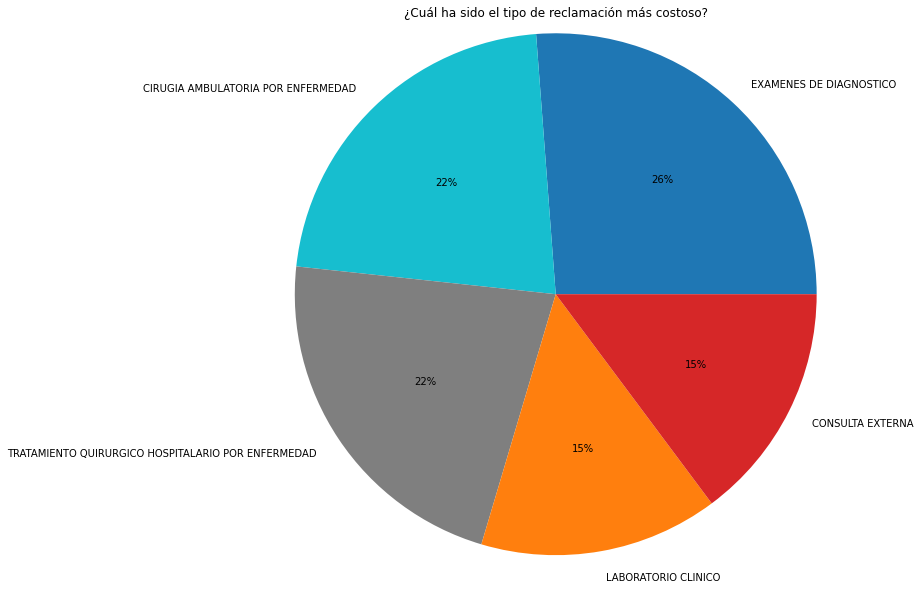

In [ ]:
fig, ax = plt.subplots(figsize =(20, 10))
ax.pie(g1.Valor_Pagado_en_Millones, labels = g1.Reclamacion, colors = ['tab:blue', 'tab:cyan', 'tab:gray', 'tab:orange', 'tab:red'], autopct='%.0f%%', radius = 1.2)
ax.set_title("¿Cuál ha sido el tipo de reclamación más costoso?")
plt.show()

## **Sexo de reclamación con su promedio de costos**

In [ ]:
g1 = modelo_tarifacion1.groupby(['Sexo_Cd'])['Valor_Pagado'].sum().reset_index().sort_values(by = 'Valor_Pagado',ascending = False)
g1['Valor_Pagado'] = (g1['Valor_Pagado']/g1['Sexo_Cd'].count())/1000000
g1['porcentaje_Pagado'] = g1['Valor_Pagado']/g1['Valor_Pagado'].sum()
g1['Valor_Pagado_en_Millones'] = g1['Valor_Pagado'].round(decimals = 0)
g1 = g1.drop(['Valor_Pagado'],axis = 1)
g1

,Sexo_Cd,porcentaje_Pagado,Valor_Pagado_en_Millones
0,F,0.602872,170695.0
1,M,0.397128,112441.0


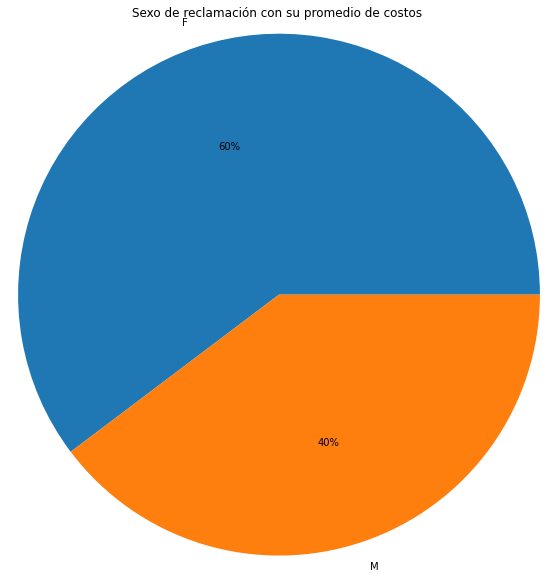

In [ ]:
fig, ax = plt.subplots(figsize =(20, 10))
ax.pie(g1.porcentaje_Pagado, labels = g1.Sexo_Cd, colors = ['tab:blue','tab:orange', 'tab:red'], autopct='%.0f%%', radius = 1.2)
ax.set_title("Sexo de reclamación con su promedio de costos ")
plt.show()

##**Distribución de clientes por mes**



In [ ]:
g1 = modelo_tarifacion1.groupby(['Mes_pago'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
g1

,Mes_pago,Asegurado_Id
9,10,138957
11,12,137926
8,9,132512
6,7,130828
4,5,130597
7,8,129719
10,11,128665
3,4,127730
2,3,126021
1,2,124349


In [ ]:
g1 = modelo_tarifacion1.groupby(['Mes_pago'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
fig = px.bar(g1, x='Mes_pago', y="Asegurado_Id",color='Asegurado_Id',  title="<b>Distribución de clientes por mes<b>", barmode = 'relative')

fig.update_layout(
    xaxis_title = 'Mes',
    yaxis_title = 'N° de clientes',
    template = 'simple_white',
    title_x = 0.25)
fig.show()

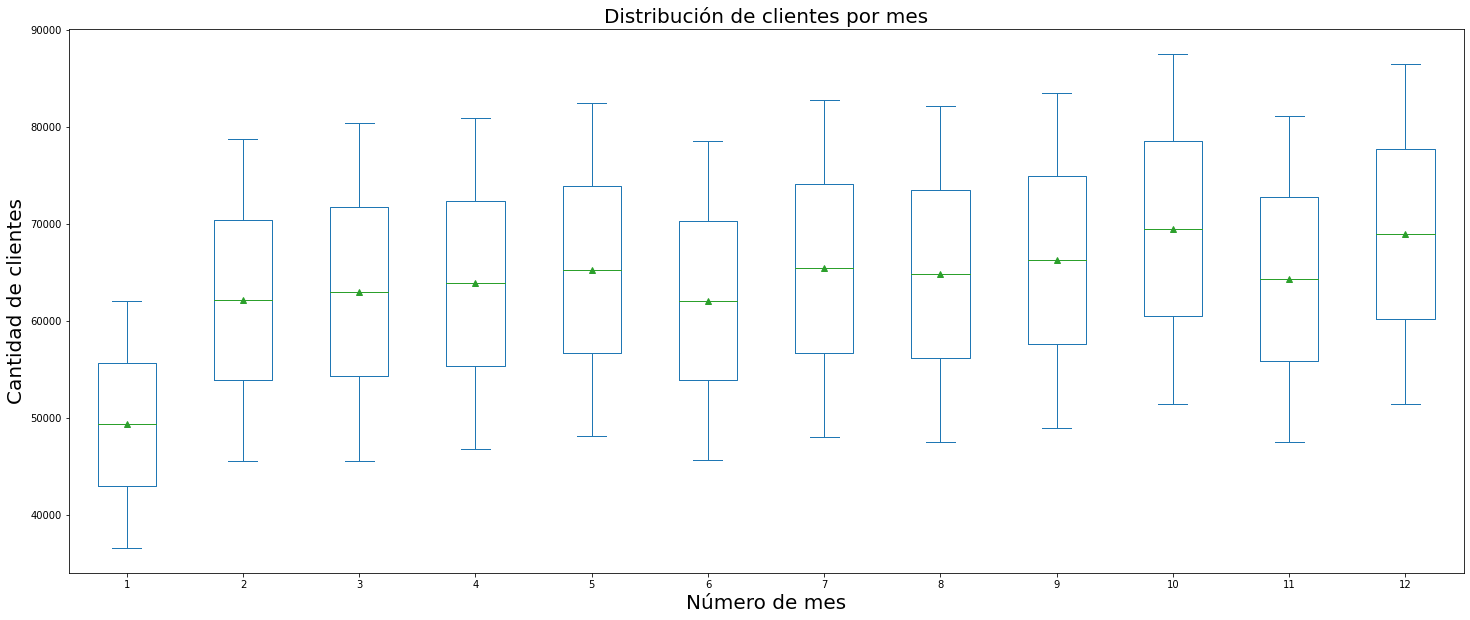

In [ ]:
base = modelo_tarifacion1.groupby(by = ['Mes_pago','Sexo_Cd'])['Asegurado_Id'].count().reset_index()
base = base.pivot(index='Sexo_Cd',columns='Mes_pago')['Asegurado_Id']
ax = base.plot(kind='box', title='Distribución de clientes por mes', showmeans=True, figsize=(25, 10))
plt.title('Distribución de clientes por mes',fontsize=20)
plt.xlabel('Número de mes',fontsize=20) 
plt.ylabel('Cantidad de clientes',fontsize=20)  
plt.show();

## **Los diagnósticos con más reclamaciones por sexo**

In [ ]:
g1 = modelo_tarifacion1.groupby(['Diagnostico_Desc','Sexo_Cd'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(7)
g1

,Diagnostico_Desc,Sexo_Cd,Asegurado_Id
1386,DIAGNÓSTICO PENDIENTE,F,804121
1387,DIAGNÓSTICO PENDIENTE,M,463630
2093,EXAMEN DE LABORATORIO,F,31059
2094,EXAMEN DE LABORATORIO,M,17141
4647,OTROS CONTROLES GENERALES DE SALUD DE RUTINA D...,F,7146
3035,"HIPOTIROIDISMO, NO ESPECIFICADO",F,6724
6937,"TUMOR MALIGNO DE LA MAMA, PARTE NO ESPECIFICADA",F,3494


In [ ]:
g1 = modelo_tarifacion1.groupby(['Diagnostico_Desc','Sexo_Cd'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(6)
fig = px.bar(g1, x='Sexo_Cd', y="Asegurado_Id", color='Diagnostico_Desc', title="<b>Los diagnósticos con más reclamaciones por sexo<b>", barmode = 'group')

fig.update_layout(
    xaxis_title = 'Sexo',
    yaxis_title = 'N° de clientes',
    template = 'simple_white',
    title_x = 0.25)
fig.show()

## **Edad de quienes más reclaman**

In [ ]:
g1 = modelo_tarifacion1.groupby(['Edad'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
g1

,Edad,Asegurado_Id
41,41,39795
42,42,39726
38,38,38871
40,40,38774
39,39,37932
43,43,37364
37,37,36459
5,5,34646
44,44,34641
36,36,34242


In [ ]:
g1 = modelo_tarifacion1.groupby(['Edad'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False)
fig = px.bar(g1, x='Edad', y="Asegurado_Id", color='Asegurado_Id', title="<b>Edad de quienes más reclaman<b>", barmode = 'group')

fig.update_layout(
    xaxis_title = 'Edad',
    yaxis_title = 'N° de Reclamaciones',
    template = 'simple_white',
    title_x = 0.5)
fig.show()

## **Serie de tiempo de comportamiento de los costos**

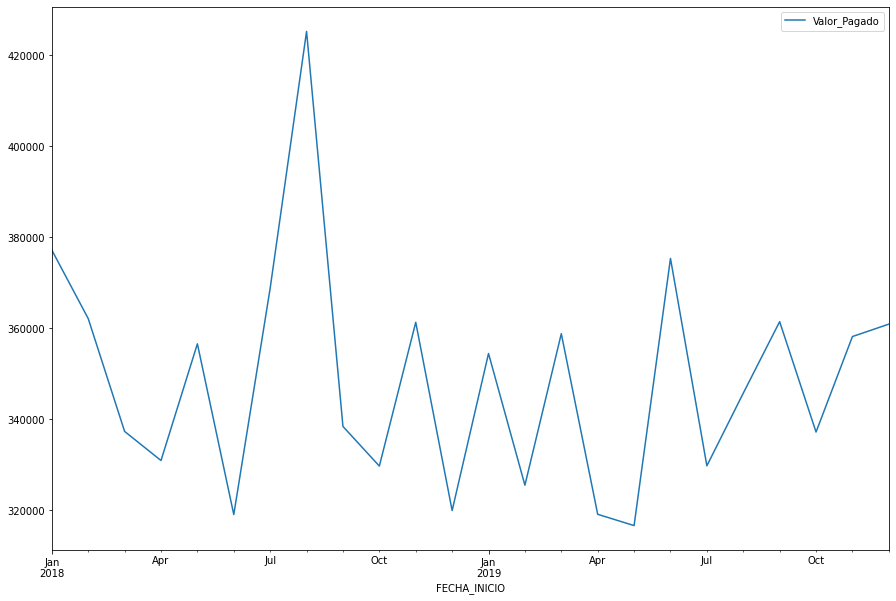

In [ ]:
modelo_tarifacion1['FECHA_INICIO'] =pd.to_datetime(modelo_tarifacion1['FECHA_INICIO'])
ts = modelo_tarifacion1.groupby(pd.Grouper(key = 'FECHA_INICIO', freq = '1M'))[['Valor_Pagado']].mean()
ts.plot(figsize=(15, 10));


In [ ]:
modelo_tarifacion1['canceo'] = modelo_tarifacion1.FECHA_CANCELACION.isnull()
modelo_tarifacion1['canceo'].value_counts()

False    1530201
Name: canceo, dtype: int64

In [ ]:
g1 = modelo_tarifacion1.groupby(['Mes_pago'])['Asegurado_Id'].count().reset_index().sort_values(by = 'Asegurado_Id',ascending = False).head(20)
fig = px.bar(g1, x='Mes_pago', y="Asegurado_Id",color='Asegurado_Id',  title="<b>Distribución de clientes por mes<b>", barmode = 'relative')

fig.update_layout(
    xaxis_title = 'Mes',
    yaxis_title = 'N° de clientes',
    template = 'simple_white',
    title_x = 0.25)
fig.show()

#**Selección de Variables**

In [ ]:
#Selecionar variables que se evaluaran en el modelo
modelo_tarifacion2 = modelo_tarifacion1[[ 'Reclamacion', 'Diagnostico_Codigo', 'Diagnostico_Desc',
       'Eventos', 'Valor_Pagado', 'Mes_pago', 'Año_pago', 'Sexo_Cd',
        'Regional', 'CANCER', 'EPOC', 'DIABETES',
       'HIPERTENSION', 'ENF_CARDIOVASCULAR',
        'Edad', 'Expuesto']]

In [ ]:
#pasar a minusculas el nombre de las variables
modelo_tarifacion2.columns = modelo_tarifacion2.columns.str.lower()

In [ ]:
modelo_tarifacion2.columns

Index(['reclamacion', 'diagnostico_codigo', 'diagnostico_desc', 'eventos',
       'valor_pagado', 'mes_pago', 'año_pago', 'sexo_cd', 'regional', 'cancer',
       'epoc', 'diabetes', 'hipertension', 'enf_cardiovascular', 'edad',
       'expuesto'],
      dtype='object')

##Escalado de variables numéricas y categórias

In [ ]:
#Variables categoricas
le = LabelEncoder()

modelo_tarifacion2['reclamacion'] = le.fit_transform(modelo_tarifacion2.reclamacion)
modelo_tarifacion2['diagnostico_codigo'] = le.fit_transform(modelo_tarifacion2.diagnostico_codigo)
modelo_tarifacion2['diagnostico_desc'] = le.fit_transform(modelo_tarifacion2.diagnostico_desc)
modelo_tarifacion2['sexo_cd'] = le.fit_transform(modelo_tarifacion2.sexo_cd)
modelo_tarifacion2['mes_pago'] = le.fit_transform(modelo_tarifacion2.mes_pago)
modelo_tarifacion2['año_pago'] = le.fit_transform(modelo_tarifacion2.año_pago)
modelo_tarifacion2['regional'] = le.fit_transform(modelo_tarifacion2.regional)

In [ ]:
#Variables Numéricas
scaler = MinMaxScaler()

modelo_tarifacion2[['eventos']] = scaler.fit_transform(modelo_tarifacion2[['eventos']])
modelo_tarifacion2[['valor_pagado']] = scaler.fit_transform(modelo_tarifacion2[['valor_pagado']])
modelo_tarifacion2[['edad']] = scaler.fit_transform(modelo_tarifacion2[['edad']])

##Features select

In [ ]:
#Reubicar la variable de salida
first_column = modelo_tarifacion2.pop('valor_pagado') 
modelo_tarifacion2.insert(0, 'valor_pagado', first_column)

In [ ]:
#Arreglo del modelo
arreglo = modelo_tarifacion2.values
X = arreglo[:,1:16]
Y = arreglo[:,0]

In [ ]:
#Seleccion de variables de acuerdo con las k puntuaciones más altas
prueba = SelectKBest(score_func=f_classif, k=15)
fit = prueba.fit(X,Y)
print("Puntaje KBest ",fit.scores_)

Puntaje KBest  [12.48942741 10.23332947  6.00233926 12.65931911  2.20820895  6.41592234
  1.32305205  2.81236566  1.95178393  1.61588715  2.11667507  1.53696448
  1.62212988  1.97261338  0.91026597]


In [ ]:
modelo = ExtraTreesRegressor(n_estimators=100,random_state=0)
modelo.fit(X,Y)
print(modelo.feature_importances_*100)

[14.52804848 16.70924426 14.14740808  2.16316869 18.61381363  3.57739708
  2.93034771  5.97705471  1.28468651  1.15584867  1.02099906  2.65346915
  0.61290324 13.66521935  0.96039139]


De acuerdo a la pruebas realizas y despues de la comparación de resultados, se consideran variables significantes al modelo:

* reclamacion
* diagnostico_codigo
* diagnostico_desc
* eventos
* mes_pago
* regional
* edad

##Nuevo Conjunto de Datos despues de la Selección de Features

In [ ]:
#Nuevo Conjunto de Datos de acuerdo a selección de Features
Modelo_Tarf = modelo_tarifacion2[['valor_pagado','reclamacion', 'diagnostico_codigo', 'diagnostico_desc','eventos', 'mes_pago','regional','edad']]

In [ ]:
#Arreglo del modelo final
arreglo = Modelo_Tarf.values
X = arreglo[:,1:8]
Y = arreglo[:,0]

#**Selección modelo**

In [ ]:
#Evaluación de modelos con la métrica de precisión raíz cuadrada del error cuadrático medio
listaModelos = []
listaModelos.append(('RL',LinearRegression()))
listaModelos.append(('DT',DecisionTreeRegressor()))
listaModelos.append(('RFR',RandomForestRegressor()))
listaModelos.append(('SGDR',SGDRegressor()))

listaResultados = []
nombres = []
scoring = 'neg_mean_squared_error'

for nom, modelo in listaModelos:
  kfold = KFold(n_splits=5, random_state=7, shuffle=True)
  res_cv = cross_val_score(modelo, X, Y, cv=kfold, scoring=scoring)
  listaResultados.append(res_cv)
  nombres.append(nom)
  print(nom, res_cv.mean()*-1, res_cv.std())
print(nombres)
print(listaResultados)
print(res_cv.mean())

RL 9.916427129870169e-06 1.344406123237906e-06
DT 1.6331539162400578e-05 1.508776254235902e-06
RFR 9.308194646103017e-06 1.2896220193355555e-06
SGDR 6.9967791762340005e+28 4.0570331501462385e+28
['RL', 'DT', 'RFR', 'SGDR']
[array([-1.20939776e-05, -8.79544092e-06, -9.49718701e-06, -1.07510105e-05,
       -8.44451968e-06]), array([-1.52606056e-05, -1.40702906e-05, -1.70903068e-05, -1.68324582e-05,
       -1.84040345e-05]), array([-1.11081442e-05, -7.88448532e-06, -9.11222128e-06, -1.04416225e-05,
       -7.99449993e-06]), array([-8.66742505e+28, -1.05304920e+29, -3.82722574e+28, -1.12188002e+29,
       -7.39952874e+27])]
-6.9967791762340005e+28


De acuerdo con los resultados obtenidos con la metrica de presión RMSE se seleciona el modelo RandomForestRegressor, ya que comparado a los demas obtuvo un menor error

#**Afinamiento de hiperparámetros**

In [ ]:
param_grid = {'bootstrap': [True, False], 
              'max_depth': [10, 60], # The maximum depth of the tree
              'max_features': ['auto', 'sqrt'], #The number of features to consider when looking for the best split
              'min_samples_leaf': [1, 2], #The minimum number of samples required to split an internal node
              'min_samples_split': [2, 5], 
              'n_estimators': [3, 5]
              }

In [ ]:
hyp_RFR = RandomizedSearchCV(RandomForestRegressor(), param_distributions = param_grid, n_iter = 20, scoring = "neg_mean_squared_error" )
hyp_RFR.fit(X,Y)

resultados = hyp_RFR.cv_results_
hyp_RFR.best_params_
pd_resultados = pd.DataFrame(resultados)
print(pd_resultados[['params','mean_test_score']].min())
print('-------------------------')
print(pd_resultados[['params','mean_test_score']])

mean_test_score   -0.000012
dtype: float64
-------------------------
                                               params  mean_test_score
0   {'n_estimators': 3, 'min_samples_split': 5, 'm...        -0.000009
1   {'n_estimators': 5, 'min_samples_split': 5, 'm...        -0.000010
2   {'n_estimators': 5, 'min_samples_split': 5, 'm...        -0.000010
3   {'n_estimators': 3, 'min_samples_split': 5, 'm...        -0.000008
4   {'n_estimators': 5, 'min_samples_split': 2, 'm...        -0.000009
5   {'n_estimators': 5, 'min_samples_split': 2, 'm...        -0.000010
6   {'n_estimators': 3, 'min_samples_split': 2, 'm...        -0.000012
7   {'n_estimators': 3, 'min_samples_split': 5, 'm...        -0.000010
8   {'n_estimators': 5, 'min_samples_split': 5, 'm...        -0.000008
9   {'n_estimators': 3, 'min_samples_split': 5, 'm...        -0.000010
10  {'n_estimators': 3, 'min_samples_split': 2, 'm...        -0.000011
11  {'n_estimators': 5, 'min_samples_split': 2, 'm...        -0.000009
12  {'n_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  if __name__ == '__main__':


In [ ]:
resultados = hyp_RFR.cv_results_
hyp_RFR.best_params_
pd_resultados = pd.DataFrame(resultados)
pd_resultados[['params','mean_test_score']]

modelo_RFR =  hyp_RFR.best_estimator_         ### Modelo con los mejores hiperparametros
modelo_RFR  

RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=2, min_samples_split=5, n_estimators=5)

# **Evaluación y selección del modelo**

In [ ]:
from sklearn.model_selection import cross_validate, GridSearchCV

In [ ]:
eva_mod1 = cross_validate(modelo_RRF,X,Y,cv = 5, scoring ="neg_mean_squared_error", return_train_score = True)
eva_mod1 = pd.DataFrame(eva_mod1)
eva_mod1.mean()

fit_time       8.751550
score_time     0.132815
test_score    -0.000008
train_score   -0.000007
dtype: float64

In [ ]:
eva_mod2 = cross_validate(RandomForestRegressor(),X,Y,cv = 5, scoring ="neg_mean_squared_error", return_train_score = True)
eva_mod2 = pd.DataFrame(eva_mod2)
eva_mod2.mean()

fit_time       512.740821
score_time      21.935061
test_score      -0.000010
train_score     -0.000001
dtype: float64